In [1]:
%matplotlib inline
from utils import read, createGraph, readGenders, functionals
from glob import iglob as glob
from os.path import exists, basename
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import scipy as sp
import pickle
import warnings
import community
import networkx as nx
import itertools
import scipy as sp 
import logging

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
logging.basicConfig(format = "%(asctime)-15s %(message)s", level = logging.DEBUG)

In [3]:
th = 2
data_dir = "../data/utterances_with_charnames/*"
info_dir = "../data/character_info/"
genre_dir = "../data/genres/*"

## Read genres

In [4]:
genres = {}

for f in glob(genre_dir):
    with open(f) as inpt:
        try:
            next(inpt)
            glist = next(inpt).strip().split(": ")[1].split(",")
            
            genres[basename(f)] = glist
            
        except StopIteration:
            logging.debug("File {} is empty".format(f))
            continue
        except Exception as e:
            logging.debug(e)

logging.info("Read {} genres files".format(len(genres)))

INFO:root:Read 1146 genres files


## Read all scripts

In [6]:
data = {}
for script in glob(data_dir):
    
    _, char_list, adj = read(script, threshold = th)

    gender_file = info_dir + basename(script)
    if exists(gender_file):
        gens, races = readGenders(gender_file)
    else:
#         logging.warning("Info for {} not found".format(basename(script)))
#         gens = defaultdict(lambda: 'unknown')
#         races = defaultdict(lambda: 'unknown')  
        continue
        

    G = createGraph(char_list, adj, gens, races)


    key = basename(script)

    data[key] = {}
    data[key]['graph'] = G
    data[key]['chars'] = char_list
    data[key]['genres'] = genres.get(key, [])


In [56]:
np.sum([nx.number_of_nodes(d['graph']) for d in data.values()])

15133

In [13]:
types = Counter([y for x in [d['genres'] for script, d in data.items()] for y in x])
print(types)
types = list(types.keys())

Counter({'Drama': 558, 'Thriller': 368, 'Comedy': 286, 'Action': 252, 'Crime': 242, 'Romance': 194, 'Adventure': 170, 'Sci-Fi': 154, 'Mystery': 143, 'Horror': 115, 'Fantasy': 115, 'Biography': 70, 'Family': 49, 'War': 34, 'History': 34, 'Sport': 32, 'Animation': 32, 'Music': 23, 'Musical': 19, 'Western': 17, 'Short': 6, 'Film-Noir': 5, 'Documentary': 1})


In [15]:
xkcd_colors = sns.xkcd_palette(["grass green", "sand", "blue", "light red", "cerulean",
                                "red", "light blue", "teal", "orange", "light green",
                                "magenta", "yellow", "sky blue", "grey", "cobalt",
                                "grass", "algae green", "coral", "cerise", "steel",
                                "hot purple", "mango", "pale lime", "rouge"])
colors = itertools.cycle(xkcd_colors)

# Pre-check
In [GENDER BIAS WITHOUT BORDERS](http://seejane.org/wp-content/uploads/gender-bias-without-borders-executive-summary.pdf), there is a ratio of 2.25 men for every women on screen (women = $30.9$%). Lets check our numbers.

In [16]:
total, males, females = 0, 0, 0
for _, d in data.items():
    G = d['graph']
    
    for i in G.nodes():
        if G.node[i]['gender'] == 'male':
            males += 1
        elif G.node[i]['gender'] == 'female':
            females += 1
        
        total += 1
        
print("total: {}".format(total))
print("males: {:.2f}%".format(float(males) / total))
print("females: {:.2f}%".format(float(females) / total))


total: 15133
males: 0.55%
females: 0.21%


What if we drop unknown?... shouldn't matter right?

In [17]:
print("males: {:.2f}%".format(float(males) / (males + females)))
print("females: {:.2f}%".format(float(females) / (males + females)))

males: 0.72%
females: 0.28%


# Graph analysis

# Degree centrality

#### Average degree

In [18]:
warnings.simplefilter("ignore")
male_deg, female_deg = [], []
for script, d in data.items():
    G = d['graph']
    degrees = nx.degree(G)
    
    male_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

In [19]:
#Remove nans

male_deg = np.array(male_deg)
female_deg = np.array(female_deg)

male_deg = male_deg[~np.isnan(male_deg)]
female_deg = female_deg[~np.isnan(female_deg)]

In [20]:
sp.stats.describe([y for x in [list(nx.degree(d['graph']).values()) for script, d in data.items()]
     for y in x])

DescribeResult(nobs=15133, minmax=(0, 48), mean=5.8992929359677522, variance=13.568630877241267, skewness=1.6124551275816692, kurtosis=4.3883336063249345)

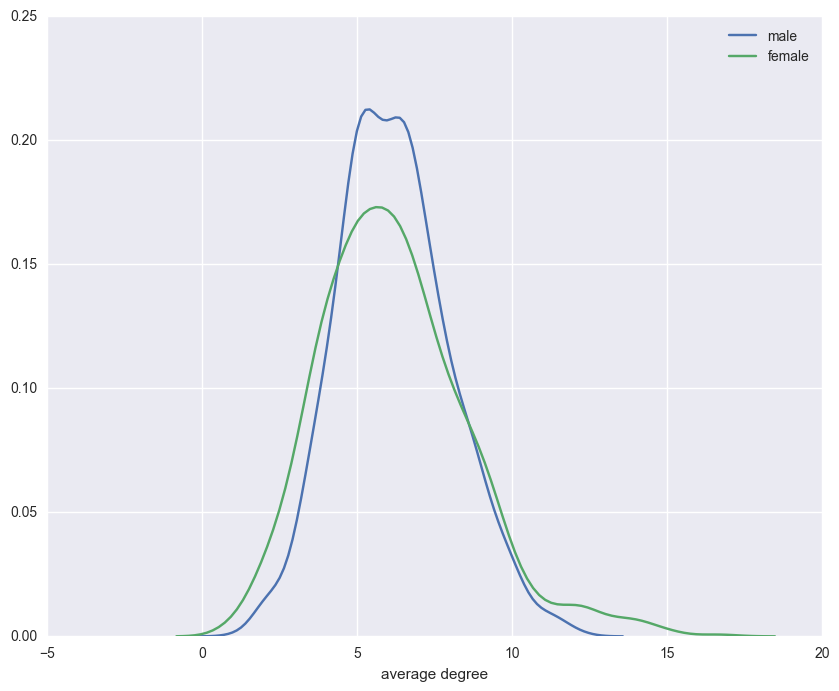

In [21]:
sns.distplot(male_deg, hist = False, label = "male");
sns.distplot(female_deg, hist = False, label = "female");
plt.legend();
plt.xlabel("average degree");

There is no real difference in the number of connections between men and women.

In [22]:
sp.stats.ttest_ind(male_deg, female_deg)

Ttest_indResult(statistic=0.043458043306698092, pvalue=0.9653408933417793)

### Based on Genre

In [23]:
res = {}
for t in types:
    male_deg, female_deg = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        degrees = nx.degree(G)

        male_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
        female_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))
    
    res[t] = {}
    res[t]['male'] = male_deg
    res[t]['female'] = female_deg

In [24]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "value"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

tmp.head()

,genre,gender,value
0,Horror,male,6.307692
1,Horror,male,5.000000
2,Horror,male,2.800000
3,Horror,male,5.636364
4,Horror,male,6.416667


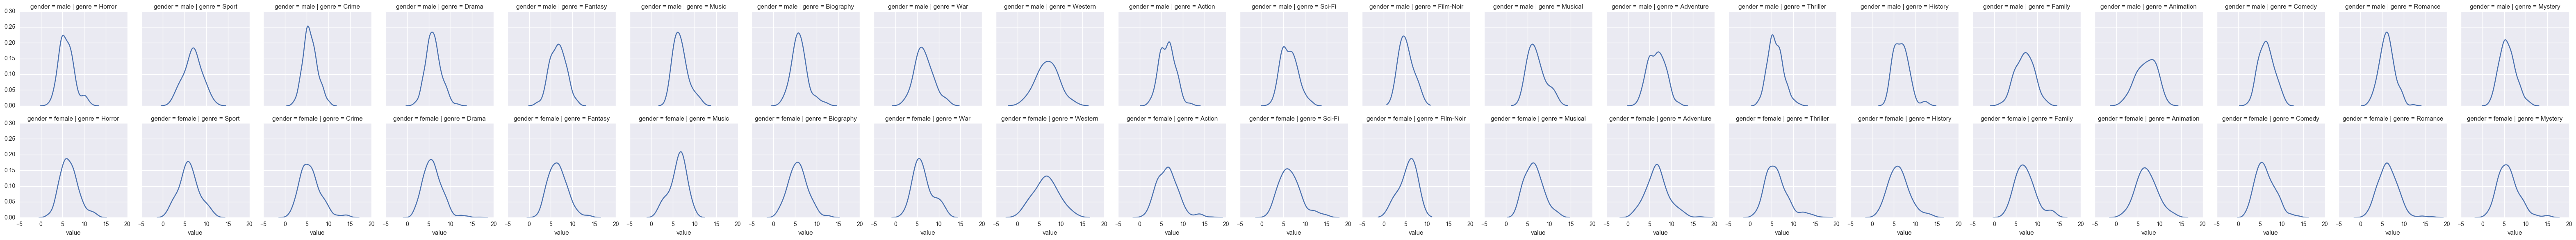

In [25]:
g = sns.FacetGrid(tmp, col = "genre", row = "gender")
g = g.map(sns.distplot, "value", hist=False)

In [26]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg)

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

__There are no significant differences between the degrees based on gender.__

In [27]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

[]


# Betweeness Centrality

#### Average centrality

In [28]:
male_cent, female_cent = [], []
for script, d in data.items():
    G = d['graph']
    cents = nx.betweenness_centrality(G)
    
    male_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

In [29]:
#Remove nans
male_cent, female_cent = np.array(male_cent), np.array(female_cent)
male_cent = male_cent[~np.isnan(male_cent)]
female_cent = female_cent[~np.isnan(female_cent)]

In [54]:
sp.stats.describe([y for x in [list(nx.betweenness_centrality(d['graph']).values()) for d in data.values()] for y in x])

DescribeResult(nobs=15133, minmax=(0.0, 1.0), mean=0.045594842347982223, variance=0.008703655574351616, skewness=3.5561931822032746, kurtosis=15.501383735343609)

Just a quick note, this is a _density_, not a probability. The AUC adds up to 1. 

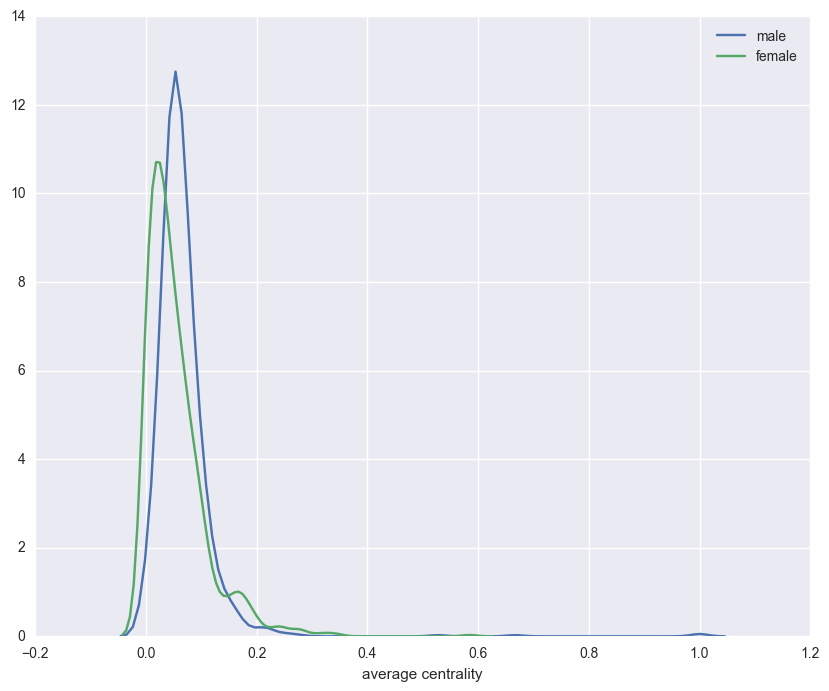

In [30]:
sns.distplot(male_cent, hist = False, label = "male");
sns.distplot(female_cent, hist = False, label = "female");
plt.legend();
plt.xlabel("average centrality");

In this case, there is a significant difference in the average centrality of male characters and female characters ($t(?) = 4.8805,\, p < 0.01$). In most of the scripts, males occupy a more central role than females.

In [31]:
sp.stats.ttest_ind(male_cent, female_cent)

Ttest_indResult(statistic=4.7001627636404653, pvalue=2.7829037955976435e-06)

### Condition on Genre

In [59]:
res = {}
for t in types:
    male_centr, female_centr = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        centralities = nx.betweenness_centrality(G)

        male_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
        female_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))
    
    res[t] = {}
    res[t]['male'] = male_centr
    res[t]['female'] = female_centr

In [60]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "value"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

tmp.head()

,genre,gender,value
0,Horror,male,0.037083
1,Horror,male,0.079365
2,Horror,male,0.106667
3,Horror,male,0.057918
4,Horror,male,0.076117


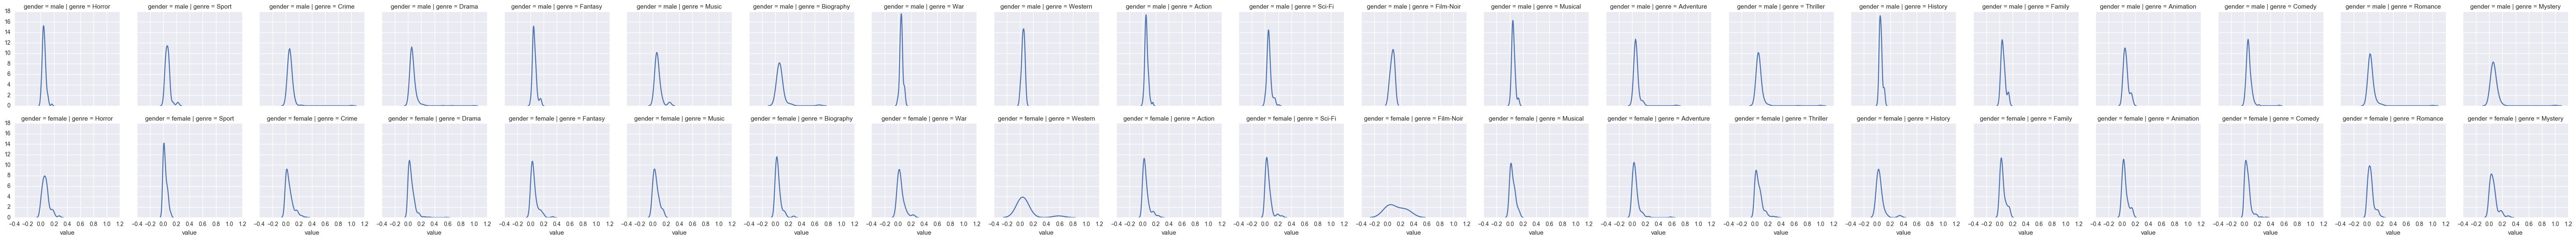

In [34]:
g = sns.FacetGrid(tmp, col = "genre", row = "gender")
g = g.map(sns.distplot, "value", hist=False)

In [35]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg)

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

__ There is a real difference in the centrality of characters in: __

In [36]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

[('Drama',
  Ttest_indResult(statistic=5.5232556979174312, pvalue=4.153975304357484e-08)),
 ('Comedy',
  Ttest_indResult(statistic=4.9376455990439743, pvalue=1.0455440426171629e-06)),
 ('Horror',
  Ttest_indResult(statistic=-4.3917086534318113, pvalue=1.7282576944537052e-05)),
 ('Sport',
  Ttest_indResult(statistic=4.3088360319331551, pvalue=6.0748376366828641e-05)),
 ('Biography',
  Ttest_indResult(statistic=3.1359686103215179, pvalue=0.0020966206657615895)),
 ('Sci-Fi',
  Ttest_indResult(statistic=2.5684064888295017, pvalue=0.010700540545397574))]

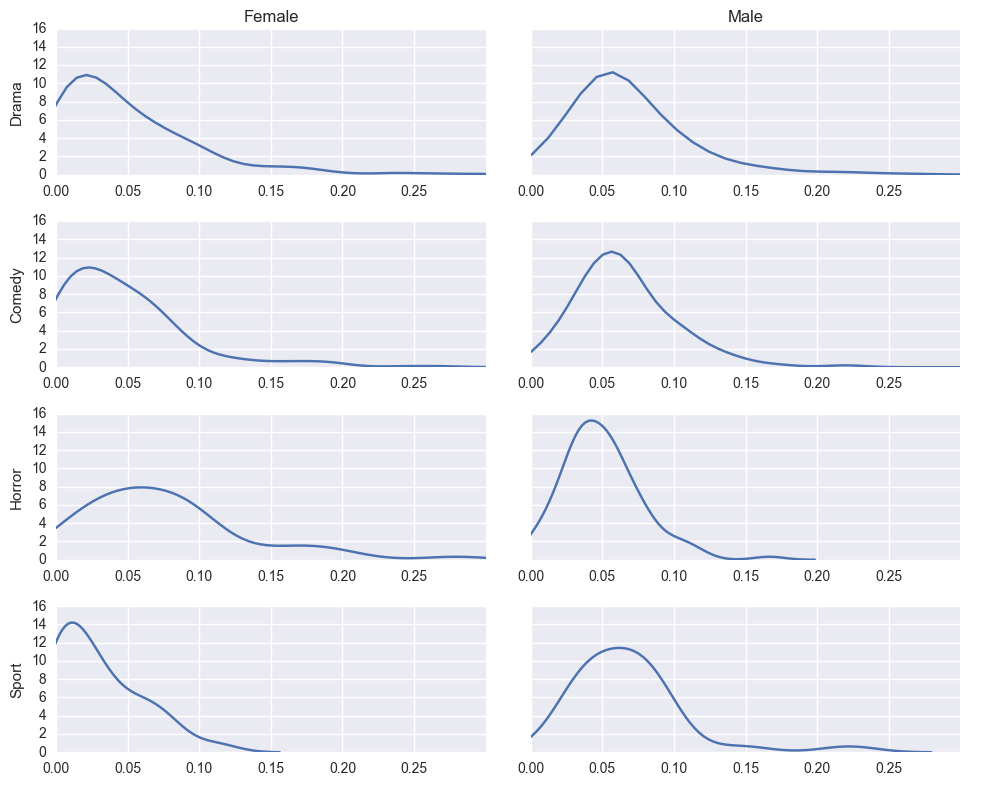

In [71]:
fig, axx = plt.subplots(4, 2, sharey = True)

for i, t in enumerate(['Drama', 'Comedy', 'Horror', 'Sport']):
    
    axx[i, 0].set_xlim((0, 0.3))
    axx[i, 1].set_xlim((0, 0.3))
    
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    sns.distplot(male_deg, hist = False, ax=axx[i, 1]);
    sns.distplot(female_deg, hist = False, ax=axx[i, 0]);

    axx[i, 0].set_ylabel(t)
    
axx[0, 0].set_title("Female")
axx[0, 1].set_title("Male")
    
# plt.legend();

fig.tight_layout()
plt.show()    

## Communities and Modularities

Extract the community structure and modularity measurement of each graph using Louvain Method. The Louvain Method was created by Blondel et. al [https://arxiv.org/abs/0803.0476]

In [38]:
communities = []
modularities = []

for t in types:
    for script, d in data.items():
        if t not in d['genres']:
            continue
        
        G = d['graph']
        parts = community.best_partition(G)
        try:
            q = community.modularity(parts, G)
        except ValueError:
            logging.debug("Script {} has no links".format(script))
    
        communities.append((t, len(set(parts.values()))))
        modularities.append((t, q))
        
communities = pd.DataFrame(communities, columns=["genre", "communities"])
modularities = pd.DataFrame(modularities, columns=["genre", "modularity"])

DEBUG:root:Script things_my_father_never_taught_me_the.txt has no links
DEBUG:root:Script things_my_father_never_taught_me_the.txt has no links
DEBUG:root:Script things_my_father_never_taught_me_the.txt has no links


In [39]:
communities.communities.describe()

count    2919.000000
mean        2.892086
std         0.902932
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         7.000000
Name: communities, dtype: float64

In [40]:
communities.groupby("genre").apply(np.mean).sort_values(by="communities")

,communities
genre,
Short,1.666667
Horror,2.565217
Romance,2.768041
Mystery,2.769231
Animation,2.781250
Thriller,2.809783
Family,2.816327
Adventure,2.817647
Fantasy,2.826087


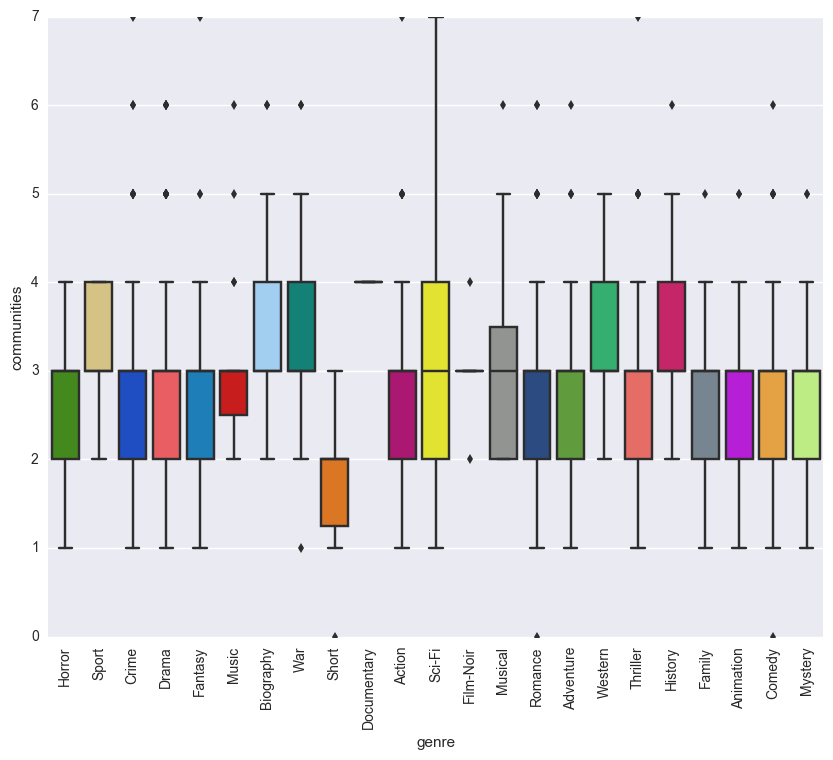

In [41]:
axs = sns.boxplot(x = "genre", y = "communities", data = communities, palette=xkcd_colors)
for item in axs.get_xticklabels():
    item.set_rotation(90)

In [42]:
modularities.modularity.describe()

count    2919.000000
mean        0.154718
std         0.081635
min         0.000000
25%         0.099769
50%         0.151342
75%         0.204082
max         0.518229
Name: modularity, dtype: float64

In [43]:
modularities.groupby("genre").apply(np.mean).sort_values(by="modularity")

,modularity
genre,
Documentary,0.101327
Short,0.115973
Horror,0.134183
Family,0.141278
Romance,0.145209
Thriller,0.147027
Action,0.150802
Mystery,0.151347
Animation,0.151497


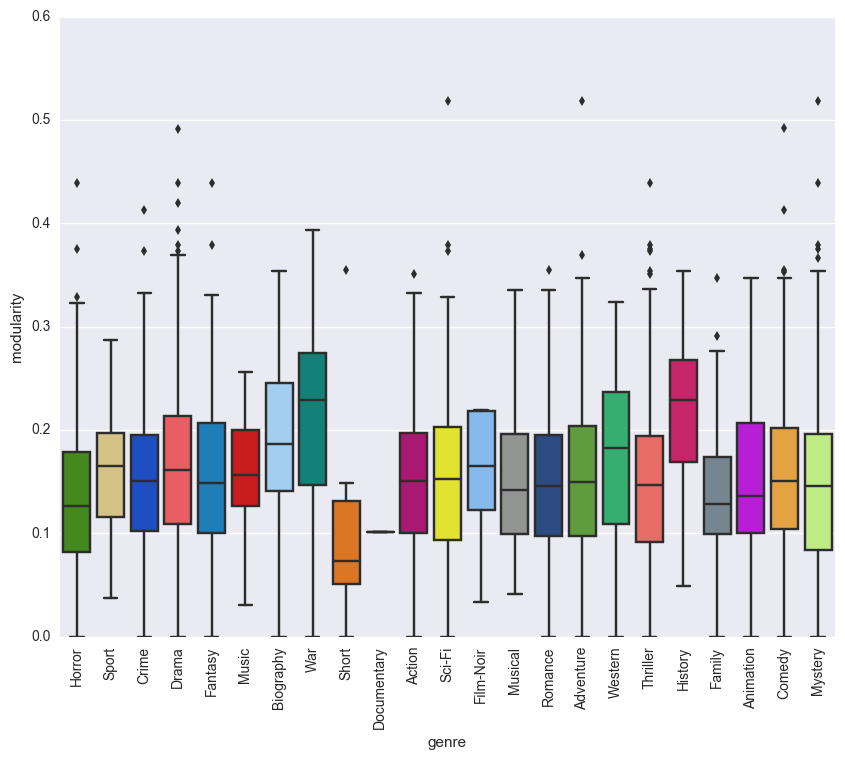

In [44]:
axs = sns.boxplot(x = "genre", y = "modularity", data = modularities, palette=xkcd_colors)
for item in axs.get_xticklabels():
    item.set_rotation(90)

## Can modularity predict genre?
The baselines are already incredibly high, so might not be much point in doing this.

In [45]:
tmp = []
for t in types:
    pos = modularities[modularities.genre == t]
    neg = modularities[modularities.genre != t]
    
    base_score = 100*np.max([len(pos) / (len(pos) + len(neg)), len(neg) / (len(pos) + len(neg))])
    
    # Baseline is most popular class in genre
    print ("{} baseline: {:.2f}%".format(t, base_score))
    
    tmp.append(base_score)
    
np.mean(tmp), np.std(tmp)

Horror baseline: 96.06%
Sport baseline: 98.90%
Crime baseline: 91.71%
Drama baseline: 80.88%
Fantasy baseline: 96.06%
Music baseline: 99.21%
Biography baseline: 97.60%
War baseline: 98.84%
Short baseline: 99.79%
Documentary baseline: 99.97%
Action baseline: 91.37%
Sci-Fi baseline: 94.72%
Film-Noir baseline: 99.83%
Musical baseline: 99.35%
Romance baseline: 93.35%
Adventure baseline: 94.18%
Western baseline: 99.42%
Thriller baseline: 87.39%
History baseline: 98.84%
Family baseline: 98.32%
Animation baseline: 98.90%
Comedy baseline: 90.20%
Mystery baseline: 95.10%


(95.652173913043484, 4.6855472302367023)

Mayyyybeeeee for drama...

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

for t in types:
    pos = modularities[modularities.genre == t].copy()
    neg = modularities[modularities.genre != t].copy()

    pos['genre_drama'] = 1
    neg['genre_drama'] = 0


    drama_data = pd.concat([pos, neg])
    
    

    X = drama_data.modularity
    X = X.reshape(X.shape[0], 1)

    Y = drama_data.genre_drama

    print("{} model: {:.2f}%".format(t, 100 * cross_val_score(LogisticRegression(), X, Y, cv = 10).mean()))

/Users/victor/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Horror model: 96.06%
Sport model: 98.90%
Crime model: 91.71%
Drama model: 80.88%
Fantasy model: 96.06%
Music model: 99.21%
Biography model: 97.60%
War model: 98.84%
Short model: 99.79%


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0